In [1]:
cd ../..

c:\Users\Josu\Documents\Workspace\Human-Benchmark\src\server\model


In [ ]:
! del /q models\logs\*
! for /d %x in (models\logs\*) do @rd /get_model

In [ ]:
%load_ext tensorboard

In [49]:
import glob
from datetime import datetime
from os import path

import chess
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from tensorflow.keras import callbacks, models, utils

from scripts import moves, bitboard

In [86]:
XX, yy_1, yy_2 = [], [], []
for file in glob.glob("data/npz/test/*.npz"):
# for file in glob.glob("data/npz/*/*.npz"):
    with np.load(file) as f:
        XX.append(f["X"]), yy_1.append(f["y_1"]), yy_2.append(f["y_2"])
X, y_1, y_2 = np.concatenate(XX), np.concatenate(yy_1), np.concatenate(yy_2)

In [87]:
X.shape, y_1.shape

((284399, 8, 8, 6), (284399,))

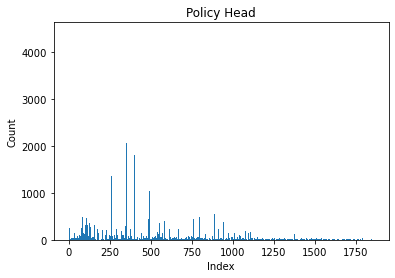

In [6]:
plt.title("Policy Head")
plt.xlabel("Index")
plt.ylabel("Count")
_ = plt.hist(y_1, bins=len(moves))

In [ ]:
plt.title("Value Head")
plt.xlabel("Score")
plt.ylabel("Density")
_, x, _ = plt.hist(y_2, bins=100, density=True)  
_ = plt.plot(x,  stats.gaussian_kde(y_2)(x))

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Activation, Conv2D, Dense, Flatten,
                                     GlobalAveragePooling2D, Input, Lambda,
                                     ReLU, Reshape, add, multiply)


def policy_head(inputs: tf.Tensor, /) -> tf.Tensor:
    x = conv_block(inputs, filters=32)
    x = Flatten()(x)
    return Dense(1858, activation="softmax")(x)


def squeeze_and_exite(inputs: tf.Tensor, /, units: int) -> tf.Tensor:
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(32, activation="relu")(x)
    x = Dense(2 * units)(x)
    x = Reshape((2, units))(x)
    W, B = Lambda(tf.unstack, arguments={"axis": 1})(x)
    Z = Activation("sigmoid")(W)
    return add((multiply((Z, inputs)), B))


def conv_block(inputs: tf.Tensor, /, filters: int, *, units: int = None, skip_connection: tf.Tensor = None) -> tf.Tensor:
    x = Conv2D(filters, (3, 3), padding="same")(inputs)
    if units is not None:
        x = squeeze_and_exite(x, units=units)
    if skip_connection is not None:
        x = add((x, skip_connection))
    return ReLU()(x)


def residual_block(inputs: tf.Tensor, /, filters: int) -> tf.Tensor:
    x = conv_block(inputs, filters=filters)
    return conv_block(x, filters=filters, units=128, skip_connection=inputs)


def get_model() -> keras.Model:
    inputs = Input(shape=(8, 8, 6))
    x = conv_block(inputs, filters=128)
    for _ in range(1):
        x = residual_block(x, filters=128)
    outputs = policy_head(x)
    return keras.Model(inputs=inputs, outputs=outputs)

In [88]:
model = get_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 8, 8, 6)]    0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 8, 8, 128)    7040        input_4[0][0]                    
__________________________________________________________________________________________________
re_lu_30 (ReLU)                 (None, 8, 8, 128)    0           conv2d_30[0][0]                  
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 8, 8, 128)    147584      re_lu_30[0][0]                   
____________________________________________________________________________________________

In [ ]:
utils.plot_model(
    model,
    to_file=f"models/png/model.png",
    show_shapes=True,
    show_layer_names=False
)

In [ ]:
callback = (
    callbacks.TensorBoard(
        log_dir=f"models/logs/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    ),
    callbacks.ModelCheckpoint(
        f"models/ser/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    )
)

In [89]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy"
)

In [91]:
_ = model.fit(
    x=X, y=y_1,
    batch_size=256,
    epochs=5,
    # callbacks=callback,
    validation_split=.2
)

Epoch 1/5
889/889 [==============================] - 574s 646ms/step - loss: 4.1095 - val_loss: 3.1100
Epoch 2/5
889/889 [==============================] - 611s 687ms/step - loss: 2.5321 - val_loss: 2.9883
Epoch 3/5
889/889 [==============================] - 619s 696ms/step - loss: 1.9737 - val_loss: 3.1162
Epoch 4/5
889/889 [==============================] - 621s 699ms/step - loss: 1.6078 - val_loss: 3.3754
Epoch 5/5
889/889 [==============================] - 590s 663ms/step - loss: 1.3541 - val_loss: 3.7074


In [ ]:
model.save("models/ser/v4")

In [ ]:
%tensorboard --logdir models/logs

In [94]:
import numpy as np
np.load("data/npz/test/ficsgamesdb_2015_standard2000_nomovetimes.npz")["X"].shape

(98790, 8, 8, 6)

In [252]:
board = chess.Board(chess.STARTING_FEN)

In [166]:
chess.Move(
    len(chess.SQUARES) - 8 - 1,
    len(chess.SQUARES) - 16 - 1
)

Move.from_uci('h7h6')

In [360]:
moves = np.array(moves)
moves[np.argsort(-model.predict(np.array([bitboard(board)])))][:, :5]

array([['c7c8', 'c7c2', 'c7d7', 'c7c5', 'c7b7']], dtype='<U5')

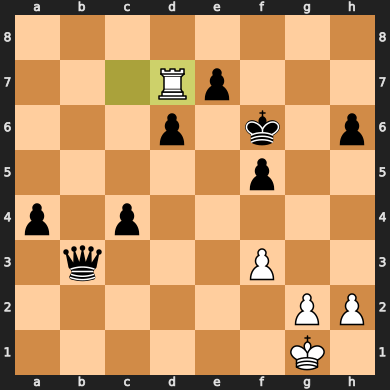

In [361]:
board.push_uci("c7d7")
board